In [0]:
companies = spark.read.parquet('/linkedin/companies')

In [0]:
import pandas as pd
companies_pd = companies.toPandas()


/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field affiliated. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType([StructField('Links', StringType(), True), StructField('location', StringType(), True), StructField('subtitle', StringType(), True), StructField('title', StringType(), True)]), True)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [0]:
companies_pd.to_csv('/dbfs/tmp/companies.csv', index=False)

In [0]:
dbutils.fs.cp("file:/dbfs/tmp/companies.csv", "file:/local/path/companies.csv")

Out[4]: True

In [0]:
temp_dir = "/Workspace/Users/lianfi@campus.technion.ac.il/temp/companies_csv"

In [0]:
from pyspark.sql.functions import to_json, struct

columns_to_keep = ['about', 'company_size', 'followers', 'type', 'updates']

companies_selected = companies.select(columns_to_keep)

# Convert updates column to a JSON string
companies_selected = companies_selected.withColumn('updates_json', to_json('updates')).drop('updates')

companies_selected.write.csv(temp_dir, mode='overwrite', header=True)

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, col, to_date
from pyspark.sql import functions as F

In [0]:
row_count = companies.count()
column_count = len(companies.columns)
print("Number of rows:", row_count)
print("Number of columns:", column_count)

Number of rows: 1422797
Number of columns: 31


#### Histogram of Post Frequency per Company Type

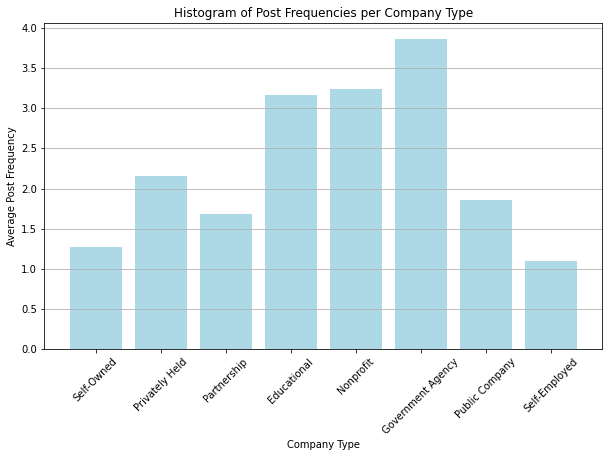

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Calculate average post frequency per company type
post_freq_per_type = companies.select("type", F.size("updates").alias("post_count")) \
                       .filter("type is not null and post_count is not null") \
                       .groupBy("type").agg(F.avg("post_count").alias("avg_post_count"))

# Convert DataFrame to Pandas for plotting
post_freq_per_type_pd = post_freq_per_type.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(post_freq_per_type_pd["type"], post_freq_per_type_pd["avg_post_count"], color='lightblue')
plt.xlabel('Company Type')
plt.ylabel('Average Post Frequency')
plt.title('Histogram of Post Frequencies per Company Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



#### Bar Chart of Most Liked Posts by Company Type

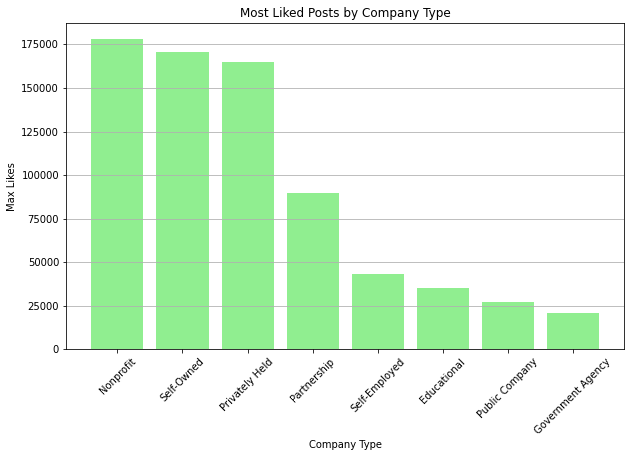

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, col, max

# Assuming `companies` is your PySpark DataFrame
most_liked_posts = companies.select(explode("updates").alias("update"), "type") \
                     .filter("update.likes_count is not null and type is not null") \
                     .groupBy("type") \
                     .agg(max("update.likes_count").alias("max_likes")) \
                     .orderBy("max_likes", ascending=False) \
                     .collect()

# Filter out rows with None values
most_liked_posts = [row for row in most_liked_posts if row["type"] is not None and row["max_likes"] is not None]

# Extract data from the result
company_types = [row["type"] for row in most_liked_posts]
max_likes = [row["max_likes"] for row in most_liked_posts]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(company_types, max_likes, color='lightgreen')
plt.xlabel('Company Type')
plt.ylabel('Max Likes')
plt.title('Most Liked Posts by Company Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


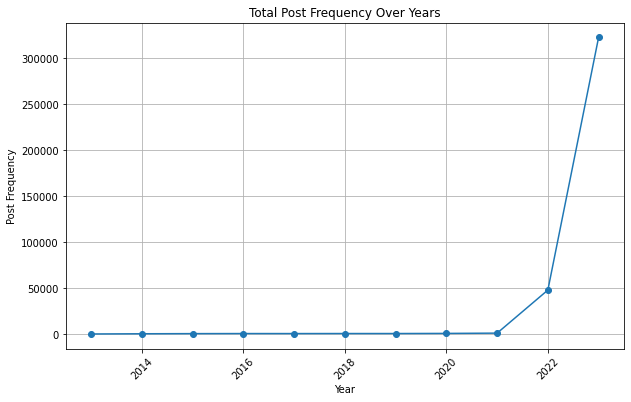

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, expr, year

# Assuming `companies` is your PySpark DataFrame
# Define a reference date
reference_date = F.lit('2023-01-01')

# Extracting post date
post_frequency_over_time = companies.select(explode("updates").alias("update"), "timestamp") \
    .select(expr("CASE \
                    WHEN update.time LIKE '%d' THEN DATE_SUB(timestamp, CAST(SUBSTRING(update.time, 1, LENGTH(update.time) - 1) AS INT)) \
                    WHEN update.time LIKE '%w' THEN DATE_SUB(timestamp, CAST(SUBSTRING(update.time, 1, LENGTH(update.time) - 1) * 7 AS INT)) \
                    WHEN update.time LIKE '%mo' THEN ADD_MONTHS(timestamp, -CAST(SUBSTRING(update.time, 1, LENGTH(update.time) - 2) AS INT)) \
                    WHEN update.time LIKE '%y' THEN ADD_MONTHS(timestamp, -CAST(SUBSTRING(update.time, 1, LENGTH(update.time) - 1) * 12 AS INT)) \
                    ELSE NULL \
                  END").alias("date")) \
    .groupBy(year("date").alias("year")).count() \
    .orderBy("year")


# Convert to Pandas DataFrame for easier plotting
post_frequency_over_time_pd = post_frequency_over_time.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(post_frequency_over_time_pd['year'], post_frequency_over_time_pd['count'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Post Frequency')
plt.title('Total Post Frequency Over Years')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### Pie Chart of Company Types Distribution

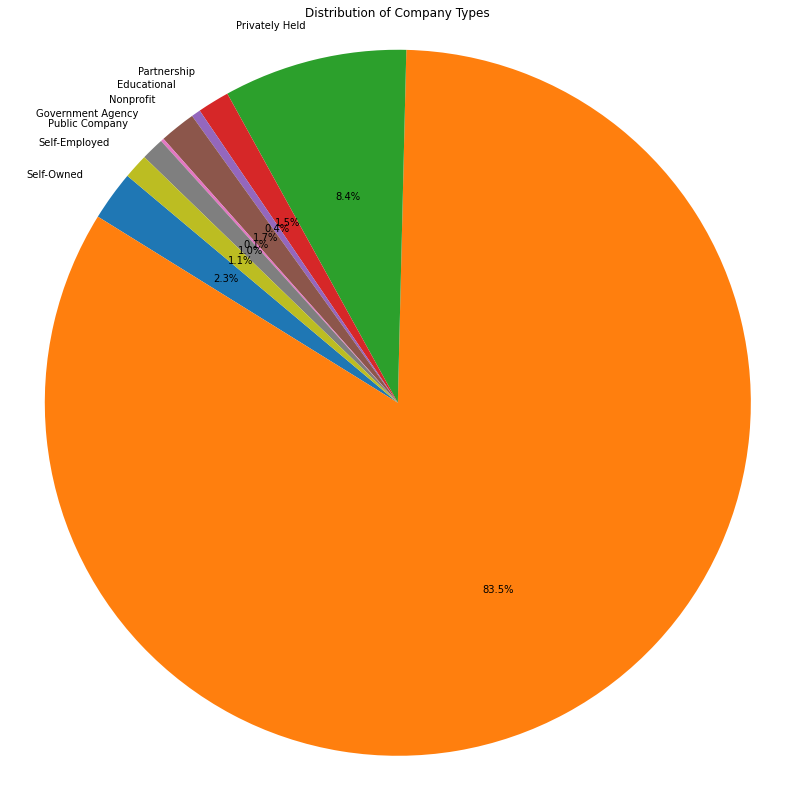

In [0]:
company_type_counts = companies.groupBy("type").count().collect()

types = [row["type"] for row in company_type_counts]
counts = [row["count"] for row in company_type_counts]

plt.figure(figsize=(14, 14))
plt.pie(counts, labels=types, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Company Types')
plt.show()


#### Sentiment Analysis of Post Text
Perform sentiment analysis on the text of the posts to determine the overall sentiment (positive, negative, neutral) 

In [0]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Out[13]: True

In [0]:
from pyspark.sql.functions import explode, udf
from pyspark.sql.types import StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a UDF (User Defined Function) to perform sentiment analysis
def analyze_sentiment(text):
    if text:
        # Get the polarity scores for the text
        scores = sid.polarity_scores(text)
        # Determine the overall sentiment based on the compound score
        if scores['compound'] >= 0.05:
            return 'positive'
        elif scores['compound'] <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    else:
        return 'neutral'

# Register the UDF
sentiment_udf = udf(analyze_sentiment, StringType())

# Assuming `companies` is your PySpark DataFrame containing the updates
# Explode the updates column to have each update as a separate row
exploded_df = companies.select(explode("updates").alias("update"), "name")

# Apply sentiment analysis to the text column of the updates
sentiment_analysis_df = exploded_df.withColumn("sentiment", sentiment_udf("update.text"))

# Group by company and sentiment, and count the occurrences
sentiment_distribution = sentiment_analysis_df.groupby("name", "sentiment").count()

# Display the distribution of sentiment across companies
sentiment_distribution.show()


+--------------------+---------+-----+
|                name|sentiment|count|
+--------------------+---------+-----+
|         CloudSnooze| negative|    1|
|UMass Memorial Me...| negative|    1|
|1ST IMPRESSIONS O...| negative|    2|
|          360 Matrix| positive|    5|
|     FOCUS Broadband| positive|   10|
| Latinas in Business| negative|    1|
|Valley Voices and...|  neutral|    1|
|Metaverse Fashion...| positive|    8|
|                 ASA|  neutral|    1|
|Aerospace Arizona...|  neutral|    2|
|              Pixafy| positive|    5|
|               Anova|  neutral|    2|
|         API Academy| positive|    6|
|     Health by Emily|  neutral|    2|
|           Acoem USA| positive|    7|
|        Alpine Media|  neutral|    1|
|Pixel Print Media...| positive|    1|
|BOTE Innovations LLC| positive|    1|
|             Angora®| positive|    3|
|            CLOUDCOM| negative|    1|
+--------------------+---------+-----+
only showing top 20 rows



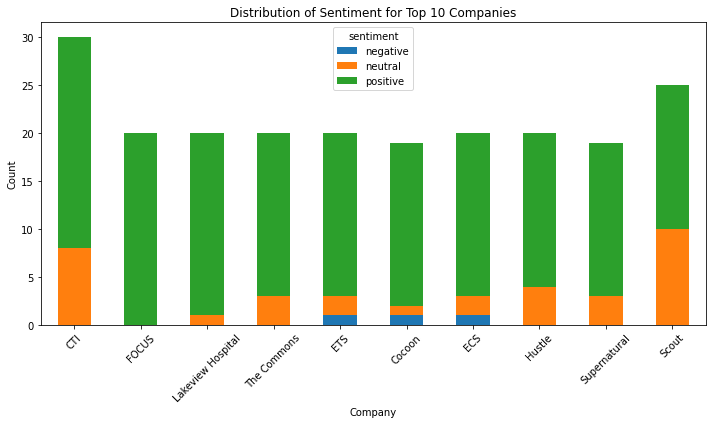

In [0]:
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to Pandas DataFrame for plotting
sentiment_distribution_pd = sentiment_distribution.toPandas()

# Pivot the DataFrame to ensure each sentiment category is a separate column
sentiment_distribution_pivot = sentiment_distribution_pd.pivot(index='name', columns='sentiment', values='count').fillna(0)

# Sort by the count of positive sentiment in descending order and select the top 10
top_10_companies = sentiment_distribution_pivot.sort_values(by='positive', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))

# Plot bars for each sentiment category for each company
top_10_companies.plot(kind='bar', stacked=True, ax=plt.gca())

# Set labels and title
plt.xlabel('Company')
plt.ylabel('Count')
plt.title('Distribution of Sentiment for Top 10 Companies')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


In [0]:
from pyspark.sql.functions import explode, udf
from pyspark.sql.types import StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid2 = SentimentIntensityAnalyzer()


# Register the UDF
sentiment_udf2 = udf(analyze_sentiment, StringType())

# Assuming `companies` is your PySpark DataFrame containing the updates
# Explode the updates column to have each update as a separate row
exploded_df_type = companies.select(explode("updates").alias("update"), "type")

# Apply sentiment analysis to the text column of the updates
sentiment_analysis_df_type = exploded_df_type.withColumn("sentiment", sentiment_udf("update.text"))

# Group by company and sentiment, and count the occurrences
sentiment_distribution_type = sentiment_analysis_df_type.groupby("type", "sentiment").count()

# Display the distribution of sentiment across companies
sentiment_distribution_type.show()


+-----------------+---------+------+
|             type|sentiment| count|
+-----------------+---------+------+
|             null| positive|  1411|
|    Self-Employed| positive| 10773|
|   Privately Held| positive|181340|
|Government Agency| negative|   399|
|    Self-Employed|  neutral|  6161|
|      Educational| negative|   692|
|Government Agency|  neutral|  1691|
|   Privately Held| negative| 14416|
|      Educational|  neutral|  4612|
|             null|  neutral|   964|
|       Self-Owned|  neutral| 12516|
|        Nonprofit|  neutral| 15026|
|             null| negative|    97|
|Government Agency| positive|  6012|
|      Educational| positive| 13608|
|   Public Company|  neutral|  6371|
|        Nonprofit| positive| 57195|
|   Public Company| negative|  1544|
|    Self-Employed| negative|   922|
|   Privately Held|  neutral| 61951|
+-----------------+---------+------+
only showing top 20 rows



In [0]:
sentiment_distribution_per_type_filtered = sentiment_distribution_type.filter(col("type").isNotNull())


In [0]:
sentiment_distribution_per_type_filtered.show()

+-----------------+---------+------+
|             type|sentiment| count|
+-----------------+---------+------+
|    Self-Employed| positive| 10773|
|   Privately Held| positive|181340|
|Government Agency| negative|   399|
|    Self-Employed|  neutral|  6161|
|      Educational| negative|   692|
|Government Agency|  neutral|  1691|
|   Privately Held| negative| 14416|
|      Educational|  neutral|  4612|
|       Self-Owned|  neutral| 12516|
|        Nonprofit|  neutral| 15026|
|Government Agency| positive|  6012|
|      Educational| positive| 13608|
|   Public Company|  neutral|  6371|
|        Nonprofit| positive| 57195|
|   Public Company| negative|  1544|
|    Self-Employed| negative|   922|
|   Privately Held|  neutral| 61951|
|      Partnership| negative|  2006|
|      Partnership| positive| 23781|
|       Self-Owned| negative|  2326|
+-----------------+---------+------+
only showing top 20 rows



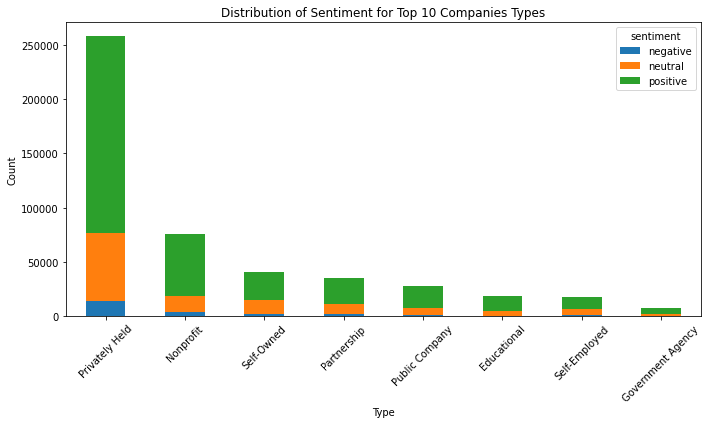

In [0]:
# Convert the PySpark DataFrame to Pandas DataFrame for plotting
sentiment_distribution_per_type_filtered = sentiment_distribution_per_type_filtered.toPandas()

# Pivot the DataFrame to ensure each sentiment category is a separate column
sentiment_distribution_pivot_type = sentiment_distribution_per_type_filtered.pivot(index='type', columns='sentiment', values='count').fillna(0)

# Sort by the count of positive sentiment in descending order and select the top 10
top_10_companies_type = sentiment_distribution_pivot_type.sort_values(by='positive', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))

# Plot bars for each sentiment category for each company
top_10_companies_type.plot(kind='bar', stacked=True, ax=plt.gca())

# Set labels and title
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution of Sentiment for Top 10 Companies Types')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import explode, col

# Explode the updates column to have each update as a separate row
exploded_df = companies.select(explode("updates").alias("update"), "name")

# Select the required columns
engagement_df = exploded_df.select("name", "update.likes_count", "update.comments_count", "update.text")

# Filter out rows where both likes_count and comments_count are not null
engagement_df_filtered = engagement_df.filter(
    engagement_df.likes_count.isNotNull() & 
    engagement_df.comments_count.isNotNull() & 
    engagement_df.text.isNotNull()
)
# Display the DataFrame schema and first few rows
engagement_df_filtered.printSchema()
engagement_df_filtered.show(5)


root
 |-- name: string (nullable = true)
 |-- likes_count: long (nullable = true)
 |-- comments_count: long (nullable = true)
 |-- text: string (nullable = true)

+--------------------+-----------+--------------+--------------------+
|                name|likes_count|comments_count|                text|
+--------------------+-----------+--------------+--------------------+
|Yeshiva Toras Cha...|          3|             2|Moving to FL? We ...|
|Yeshiva Toras Cha...|          4|             1|Moving to FL? We ...|
|           Interadev|          2|             1|Outsourcing is ha...|
|Core Engineering ...|         49|            14|With a heavy hear...|
|             NIX+BOW|          1|             1|10 years ago I ex...|
+--------------------+-----------+--------------+--------------------+
only showing top 5 rows



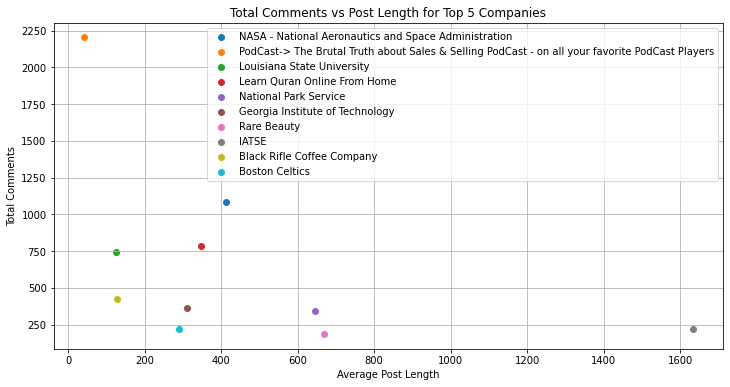

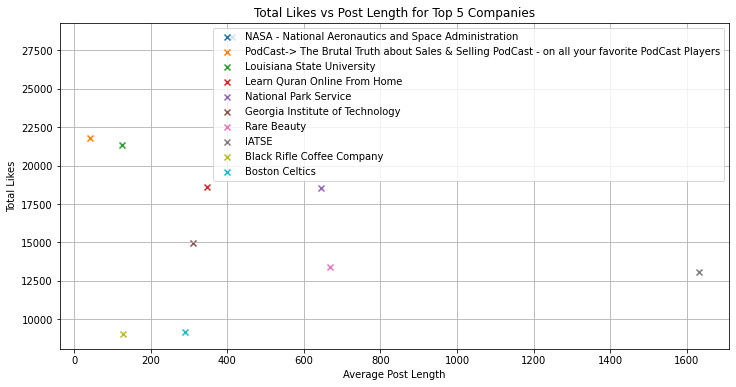

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import explode, col, length, sum as spark_sum, avg


# Explode the updates column to have each update as a separate row
exploded_df = companies.select(explode("updates").alias("update"), "name")

# Select the required columns
engagement_df = exploded_df.select("name", "update.likes_count", "update.comments_count", "update.text")

# Filter out rows where both likes_count and comments_count are not null
engagement_df_filtered = engagement_df.filter(
    engagement_df.likes_count.isNotNull() & 
    engagement_df.comments_count.isNotNull() & 
    engagement_df.text.isNotNull()
)
# Calculate the length of the post text
engagement_df_with_length = engagement_df_filtered.withColumn("text_length", length("text"))

# Group by company and calculate total likes and comments
engagement_summary = engagement_df_with_length.groupBy("name").agg(
    spark_sum("likes_count").alias("total_likes"),
    spark_sum("comments_count").alias("total_comments"),
    avg("text_length").alias("avg_text_length")
)

# Select the top 10 companies based on total engagement (likes + comments)
top_engaged_companies = engagement_summary.withColumn("total_engagement", col("total_likes") + col("total_comments")) \
    .orderBy(col("total_engagement").desc()).limit(10)

# Convert to Pandas DataFrame for plotting
top_engaged_companies_pd = top_engaged_companies.toPandas()

# Plot scatter plot for comments
plt.figure(figsize=(12, 6))
for idx, row in top_engaged_companies_pd.iterrows():
    plt.scatter(row["avg_text_length"], row["total_comments"], label=row["name"], marker='o')

plt.xlabel('Average Post Length')
plt.ylabel('Total Comments')
plt.title('Total Comments vs Post Length for Top 5 Companies')
plt.legend()
plt.grid(True)
plt.show()

# Plot scatter plot for likes
plt.figure(figsize=(12, 6))
for idx, row in top_engaged_companies_pd.iterrows():
    plt.scatter(row["avg_text_length"], row["total_likes"], label=row["name"], marker='x')

plt.xlabel('Average Post Length')
plt.ylabel('Total Likes')
plt.title('Total Likes vs Post Length for Top 5 Companies')
plt.legend()
plt.grid(True)
plt.show()


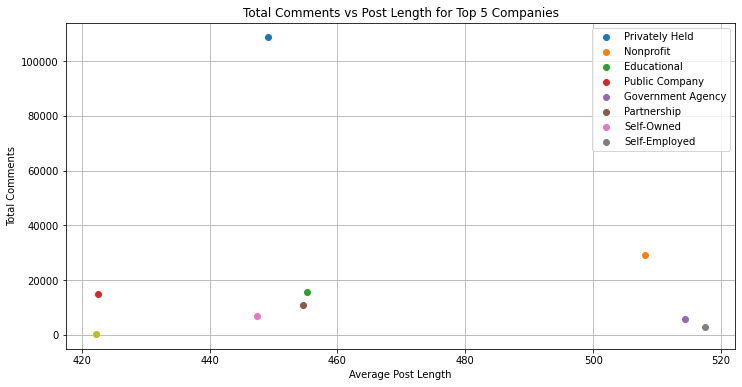

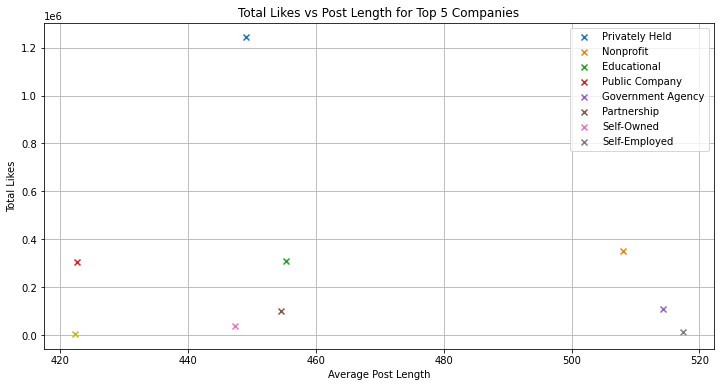

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import explode, col, length, sum as spark_sum, avg


# Explode the updates column to have each update as a separate row
exploded_df = companies.select(explode("updates").alias("update"), "type")

# Select the required columns
engagement_df = exploded_df.select("type", "update.likes_count", "update.comments_count", "update.text")

# Filter out rows where both likes_count and comments_count are not null
engagement_df_filtered = engagement_df.filter(
    engagement_df.likes_count.isNotNull() & 
    engagement_df.comments_count.isNotNull() & 
    engagement_df.text.isNotNull()
)
# Calculate the length of the post text
engagement_df_with_length = engagement_df_filtered.withColumn("text_length", length("text"))

# Group by company and calculate total likes and comments
engagement_summary = engagement_df_with_length.groupBy("type").agg(
    spark_sum("likes_count").alias("total_likes"),
    spark_sum("comments_count").alias("total_comments"),
    avg("text_length").alias("avg_text_length")
)

# Select the top 10 companies based on total engagement (likes + comments)
top_engaged_companies = engagement_summary.withColumn("total_engagement", col("total_likes") + col("total_comments")) \
    .orderBy(col("total_engagement").desc()).limit(10)

# Convert to Pandas DataFrame for plotting
top_engaged_companies_pd = top_engaged_companies.toPandas()

# Plot scatter plot for comments
plt.figure(figsize=(12, 6))
for idx, row in top_engaged_companies_pd.iterrows():
    plt.scatter(row["avg_text_length"], row["total_comments"], label=row["type"], marker='o')

plt.xlabel('Average Post Length')
plt.ylabel('Total Comments')
plt.title('Total Comments vs Post Length for Top 5 Companies')
plt.legend()
plt.grid(True)
plt.show()

# Plot scatter plot for likes
plt.figure(figsize=(12, 6))
for idx, row in top_engaged_companies_pd.iterrows():
    plt.scatter(row["avg_text_length"], row["total_likes"], label=row["type"], marker='x')

plt.xlabel('Average Post Length')
plt.ylabel('Total Likes')
plt.title('Total Likes vs Post Length for Top 5 Companies')
plt.legend()
plt.grid(True)
plt.show()


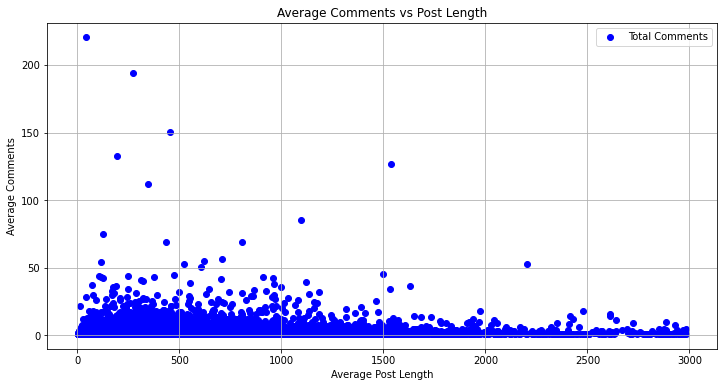

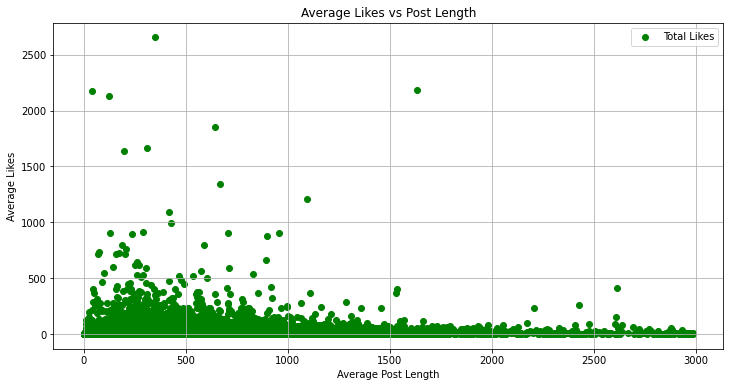

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import explode, length, sum as spark_sum, avg

# Explode the updates column to have each update as a separate row
exploded_df = companies.select("name",explode("updates").alias("update"))

# Select the required columns
engagement_df = exploded_df.select("name", "update.likes_count", "update.comments_count", "update.text")

# Filter out rows where both likes_count and comments_count are not null
engagement_df_filtered = engagement_df.filter(
    engagement_df.likes_count.isNotNull() & 
    engagement_df.comments_count.isNotNull() & 
    engagement_df.text.isNotNull()
)
# Calculate the length of the post text
engagement_df_with_length = engagement_df_filtered.withColumn("text_length", length("text"))

# Group by company and calculate total likes and comments
engagement_summary = engagement_df_with_length.groupBy("name").agg(
    avg("likes_count").alias("total_likes"),
    avg("comments_count").alias("total_comments"),
    avg("text_length").alias("avg_text_length")
)

# Convert to Pandas DataFrame for plotting
engagement_summary_pd = engagement_summary.toPandas()

# Filter out outlier data points
engagement_summary_pd = engagement_summary_pd[(engagement_summary_pd["total_comments"] != engagement_summary_pd["total_comments"].max()) &
                                              (engagement_summary_pd["total_likes"] != engagement_summary_pd["total_likes"].max())]

# Plot scatter plot for comments
plt.figure(figsize=(12, 6))
plt.scatter(engagement_summary_pd["avg_text_length"], engagement_summary_pd["total_comments"], color='blue', label='Total Comments')
plt.xlabel('Average Post Length')
plt.ylabel('Average Comments')
plt.title('Average Comments vs Post Length')
plt.legend()
plt.grid(True)
plt.show()

# Plot scatter plot for likes
plt.figure(figsize=(12, 6))
plt.scatter(engagement_summary_pd["avg_text_length"], engagement_summary_pd["total_likes"], color='green', label='Total Likes')
plt.xlabel('Average Post Length')
plt.ylabel('Average Likes')
plt.title('Average Likes vs Post Length')
plt.legend()
plt.grid(True)
plt.show()


#### Number of Likes & Comments compared to Number of Followers

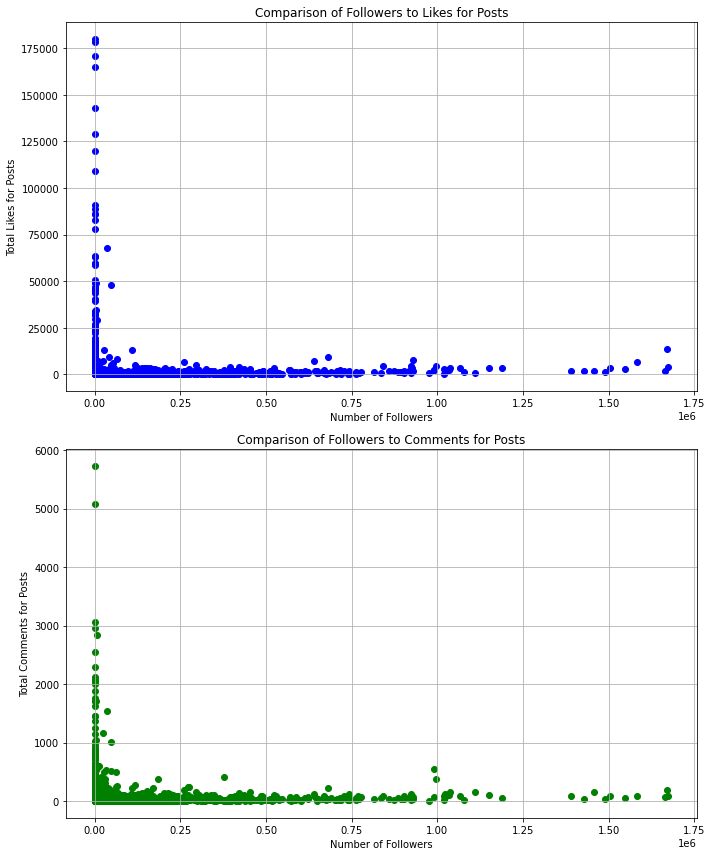

In [0]:
from pyspark.sql.functions import sum
import matplotlib.pyplot as plt

threshold = 179322

# Explode the 'updates' array to have each update as a separate row
exploded_df = companies.select("name", "followers", explode("updates").alias("update"))

# Filter out null values for followers, likes, and comments
filtered_df = exploded_df.filter("followers is not null and update.likes_count is not null and update.comments_count is not null")
filtered_df = filtered_df[filtered_df['followers'] < threshold]

# Group by company and aggregate the sum of followers, likes, and comments for posts
grouped_df = filtered_df.groupBy("name").agg({"followers": "sum", "update.likes_count": "sum", "update.comments_count": "sum"})

# Rename the aggregated columns for clarity
grouped_df = grouped_df.withColumnRenamed("sum(followers)", "total_followers")
grouped_df = grouped_df.withColumnRenamed("sum(update.likes_count AS likes_count)", "total_likes")
grouped_df = grouped_df.withColumnRenamed("sum(update.comments_count AS comments_count)", "total_comments")

# Convert DataFrame to Pandas for plotting
grouped_pd = grouped_df.toPandas()

# Plotting
plt.figure(figsize=(10, 12))

# Scatter plot for followers vs total likes
plt.subplot(2, 1, 1)
plt.scatter(grouped_pd["total_followers"], grouped_pd["total_likes"], color='blue')
plt.xlabel('Number of Followers')
plt.ylabel('Total Likes for Posts')
plt.title('Comparison of Followers to Likes for Posts')
plt.grid(True)
# Scatter plot for followers vs total comments
plt.subplot(2, 1, 2)
plt.scatter(grouped_pd["total_followers"], grouped_pd["total_comments"], color='green')
plt.xlabel('Number of Followers')
plt.ylabel('Total Comments for Posts')
plt.title('Comparison of Followers to Comments for Posts')
plt.grid(True)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


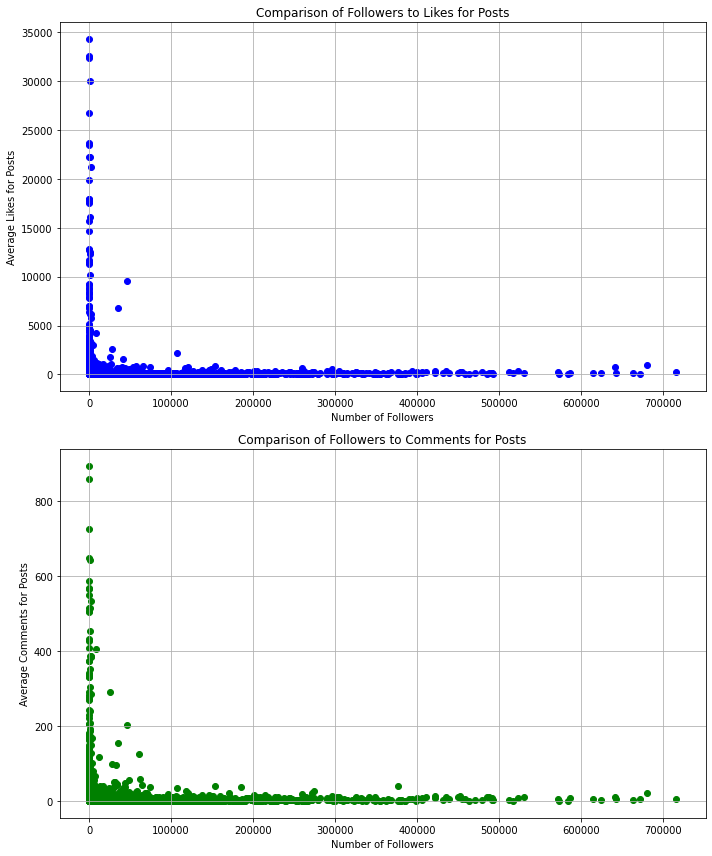

In [0]:
from pyspark.sql.functions import sum
import matplotlib.pyplot as plt

threshold = 179322

# Explode the 'updates' array to have each update as a separate row
exploded_df = companies.select("name", "followers", explode("updates").alias("update"))

# Filter out null values for followers, likes, and comments
filtered_df = exploded_df.filter("followers is not null and update.likes_count is not null and update.comments_count is not null")
filtered_df = filtered_df[filtered_df['followers'] < 76326]

# Group by company and aggregate the sum of followers, likes, and comments for posts
grouped_df = filtered_df.groupBy("name").agg({"followers": "sum", "update.likes_count": "avg", "update.comments_count": "avg"})

# Rename the aggregated columns for clarity
grouped_df = grouped_df.withColumnRenamed("sum(followers)", "total_followers")
grouped_df = grouped_df.withColumnRenamed("avg(update.likes_count AS likes_count)", "total_likes")
grouped_df = grouped_df.withColumnRenamed("avg(update.comments_count AS comments_count)", "total_comments")
grouped_df = grouped_df[grouped_df['total_comments'] < 5734]
grouped_df = grouped_df[grouped_df['total_likes'] < 35000]
# Convert DataFrame to Pandas for plotting
grouped_pd = grouped_df.toPandas()


# Plotting
plt.figure(figsize=(10, 12))

# Scatter plot for followers vs total likes
plt.subplot(2, 1, 1)
plt.scatter(grouped_pd["total_followers"], grouped_pd["total_likes"], color='blue')
plt.xlabel('Number of Followers')
plt.ylabel('Average Likes for Posts')
plt.title('Comparison of Followers to Likes for Posts')
plt.grid(True)
# Scatter plot for followers vs total comments
plt.subplot(2, 1, 2)
plt.scatter(grouped_pd["total_followers"], grouped_pd["total_comments"], color='green')
plt.xlabel('Number of Followers')
plt.ylabel('Average Comments for Posts')
plt.title('Comparison of Followers to Comments for Posts')
plt.grid(True)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [0]:
import re

def count_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    emojis = re.findall(emoji_pattern, text)
    return len(emojis)

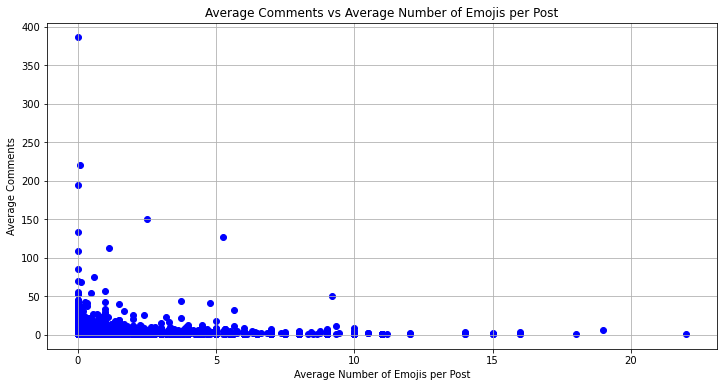

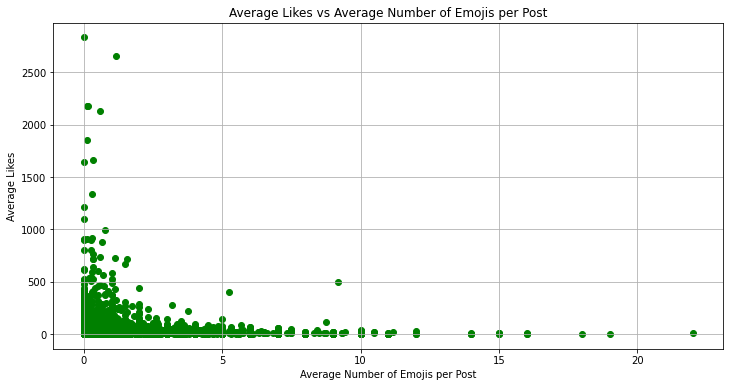

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import explode, length, sum as spark_sum, avg, udf
from pyspark.sql.types import IntegerType  # Import IntegerType for UDF definition

# Register the UDF
count_emojis_udf = udf(count_emojis, IntegerType())

# Explode the updates column to have each update as a separate row
exploded_df = companies.select("name", explode("updates").alias("update"))

# Select the required columns
engagement_df = exploded_df.select("name", "update.likes_count", "update.comments_count", "update.text")

# Filter out rows where both likes_count and comments_count are not null
engagement_df_filtered = engagement_df.filter(
    engagement_df.likes_count.isNotNull() & 
    engagement_df.comments_count.isNotNull() & 
    engagement_df.text.isNotNull()
)

# Apply the UDF to calculate the number of emojis in each post
engagement_df_with_emojis = engagement_df_filtered.withColumn("num_emojis", count_emojis_udf("text"))

# Group by company and calculate average number of emojis per post
emoji_summary = engagement_df_with_emojis.groupBy("name").agg(
    avg("num_emojis").alias("avg_num_emojis"),
    avg("likes_count").alias("total_likes"),
    avg("comments_count").alias("total_comments")
)

# Convert to Pandas DataFrame for plotting
emoji_summary_pd = emoji_summary.toPandas()



# Plot scatter plot for comments
plt.figure(figsize=(12, 6))
plt.scatter(emoji_summary_pd["avg_num_emojis"], emoji_summary_pd["total_comments"], color='blue', label='Total Comments')
plt.xlabel('Average Number of Emojis per Post')
plt.ylabel('Average Comments')
plt.title('Average Comments vs Average Number of Emojis per Post')
plt.grid(True)
plt.show()

# Plot scatter plot for likes
plt.figure(figsize=(12, 6))
plt.scatter(emoji_summary_pd["avg_num_emojis"], emoji_summary_pd["total_likes"], color='green', label='Total Likes')
plt.xlabel('Average Number of Emojis per Post')
plt.ylabel('Average Likes')
plt.title('Average Likes vs Average Number of Emojis per Post')
plt.grid(True)
plt.show()


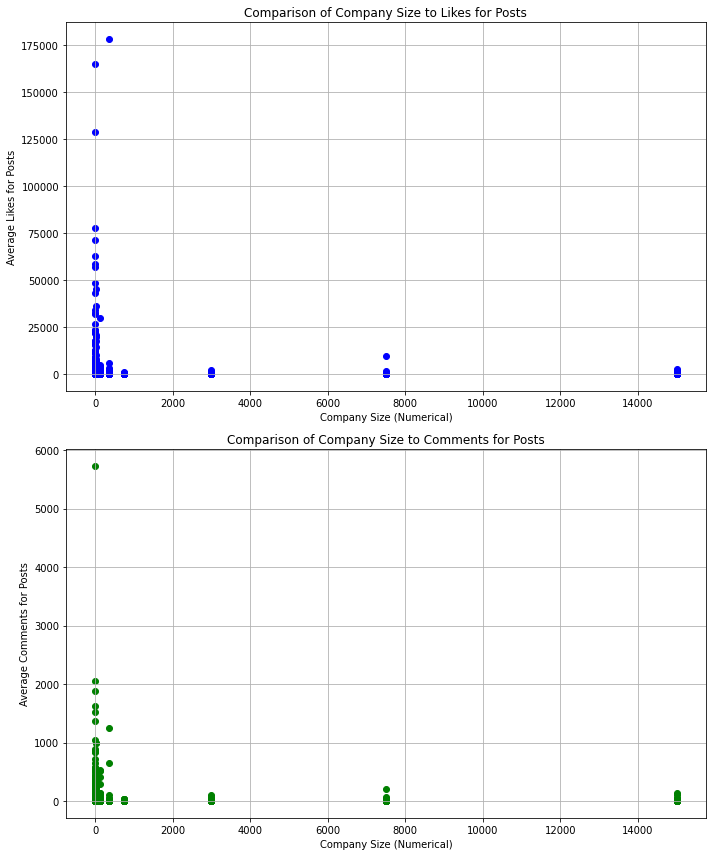

In [0]:
from pyspark.sql.functions import col, explode

# Define a mapping dictionary for company size ranges


size_mapping = {
    "501-1,000 employees": 750,
    "5,001-10,000 employees": 7500,
    "11-50 employees":30,
    "201-500 employees":350,
    "10,001+ employees":15000,
    "2-10 employees":6,
    "1,001-5,000 employees":3000,
    "1 employee":1,
    "51-200 employees":125
}

# User-defined function (UDF) to map company size range to numerical value
def map_size_to_numeric(size):
    return size_mapping[size]

# Convert the mapping dictionary to a DataFrame
size_mapping_df = spark.createDataFrame([(k, v) for k, v in size_mapping.items()], ["company_size", "numeric_size"])

# Explode the 'updates' array to have each update as a separate row
exploded_df = companies.select("name", "company_size", explode("updates").alias("update"))

# Join the DataFrame with the company size mapping DataFrame
exploded_df = exploded_df.join(size_mapping_df, exploded_df.company_size == size_mapping_df.company_size, "left_outer")

# Filter out null values for company size, likes, and comments
filtered_df = exploded_df.filter("numeric_size is not null and update.likes_count is not null and update.comments_count is not null")

# Group by company and aggregate the sum of likes and comments for posts
grouped_df = filtered_df.groupBy("name", "numeric_size").agg({"update.likes_count": "avg", "update.comments_count": "avg"})

# Rename the aggregated columns for clarity
grouped_df = grouped_df.withColumnRenamed("avg(update.likes_count AS likes_count)", "total_likes")
grouped_df = grouped_df.withColumnRenamed("avg(update.comments_count AS comments_count)", "total_comments")

# Convert DataFrame to Pandas for plotting
grouped_pd = grouped_df.toPandas()

# Plotting
plt.figure(figsize=(10, 12))

# Scatter plot for company size vs total likes
plt.subplot(2, 1, 1)
plt.scatter(grouped_pd["numeric_size"], grouped_pd["total_likes"], color='blue')
plt.xlabel('Company Size (Numerical)')
plt.ylabel('Average Likes for Posts')
plt.title('Comparison of Company Size to Likes for Posts')
plt.grid(True)

# Scatter plot for company size vs total comments
plt.subplot(2, 1, 2)
plt.scatter(grouped_pd["numeric_size"], grouped_pd["total_comments"], color='green')
plt.xlabel('Company Size (Numerical)')
plt.ylabel('Average Comments for Posts')
plt.title('Comparison of Company Size to Comments for Posts')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [0]:
# Extract the company size column from the DataFrame
company_size_column = companies.select("company_size")

# Drop any null values in the company size column
company_size_column = company_size_column.dropna()

# Extract the unique company size options
company_sizes = company_size_column.distinct().rdd.map(lambda row: row[0]).collect()

# Display the unique company size options
print("Unique Company Sizes:")
for size in company_sizes:
    print(size)
""

Unique Company Sizes:
501-1,000 employees
5,001-10,000 employees
11-50 employees
201-500 employees
10,001+ employees
2-10 employees
1,001-5,000 employees
1 employee
51-200 employees
Out[29]: ''